# Before Lecture

- Best Assignment 5 presentation
- Final Exam Q&A
- Project Q&A
- Presentation Q&A

# Housekeeping

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV
import patsy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, scale
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
import shap
import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingRegressor
from sklearn.inspection import DecisionBoundaryDisplay


# ADABoost

- [A beautiful illustration](https://www.youtube.com/watch?v=LsK-xG1cLYA)
    - ADABoost is a sequence of stumps that being used as a *stump forest*.
    - This Josh Starmer is definitely among the best teachers online.

Algorithm
1. Initialisation, each obs has equal weight as $w_i=1/n$.
2. Train a weak learner $t$ (a stump: one root with only two leaves).
3. Find error $\epsilon_t = \sum_{i=1}^n w_i \textbf{1}(\text{wrong classification})$. Obviously, $\epsilon\in(0,1)$. We give a little margin if it is exactly equal to $0$ or $1$.
4. Find the weight of this weak learner $\alpha_t = \frac{1}{2}\ln\left(\frac{1-\epsilon_t}{\epsilon_t}\right)$. Small error had large weight, this is intuitive.
5. Now reweight the ovservations/data, so that the misclassified obs receive more weight and be taken care of for the next round. This is the idea of boosting. $w_i\leftarrow w_i \exp(\alpha_t)$ if $i$ is misclassified; and $w_i\leftarrow w_i \exp(-\alpha_t)$ if $i$ is correctly classified.
    - You must normalise the weight to sum up to $1$ (normalisation)
6. Repeat until many stumps are generated **sequentially**.
    - Because of various re-weighting, some stumps are good at a certain observations while others are good at something else. They are specialised.
7. At last, collect ALL weak learners and form decision in **parallel**!
    - Every stump has a vote! But each has its weight $\alpha_t$.
    - Add up all the weighted vote for category $1$
    - Add up all the weighted vote for category $0$
    - Make decision based on votes!

In [2]:
# Construct dataset
X1, y1 = make_gaussian_quantiles(
    cov=2.0, n_samples=200, n_features=2, n_classes=2, random_state=1
)
X2, y2 = make_gaussian_quantiles(
    mean=(3, 3), cov=1.5, n_samples=300, n_features=2, n_classes=2, random_state=1
)


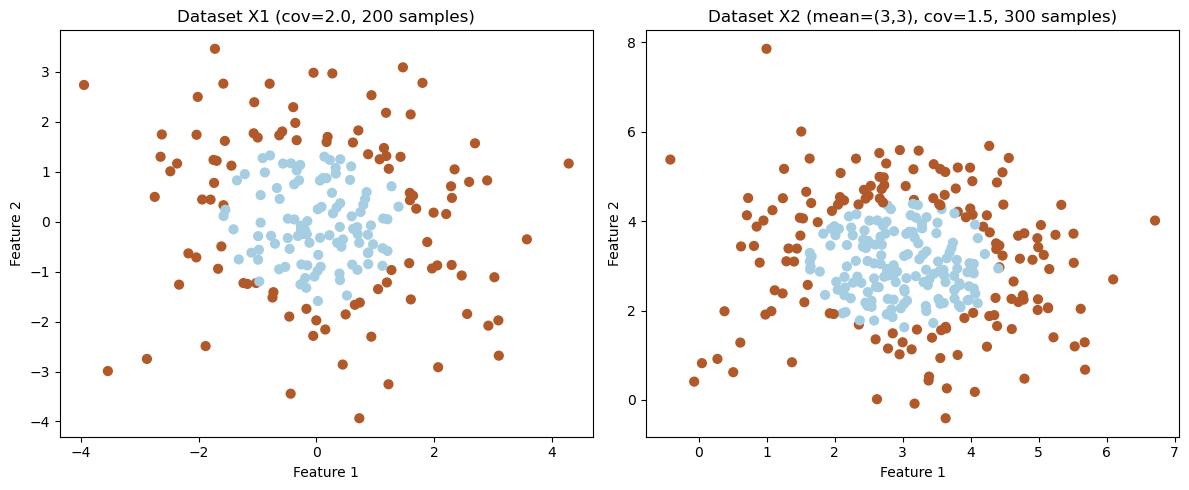

In [3]:
plt.figure(figsize=(12, 5))


#  X1
plt.subplot(1, 2, 1)
plt.scatter(X1[:, 0], X1[:, 1], c=y1, cmap=plt.cm.Paired, s=40) # type: ignore
plt.title("Dataset X1 (cov=2.0, 200 samples)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")


# X2
plt.subplot(1, 2, 2)
plt.scatter(X2[:, 0], X2[:, 1], c=y2, cmap=plt.cm.Paired, s=40) # type: ignore
plt.title("Dataset X2 (mean=(3,3), cov=1.5, 300 samples)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")


plt.tight_layout()
plt.show()

In [4]:
X = np.concatenate((X1, X2))
y = np.concatenate((y1, 1-y2 ))

Text(0, 0.5, 'Feature 2')

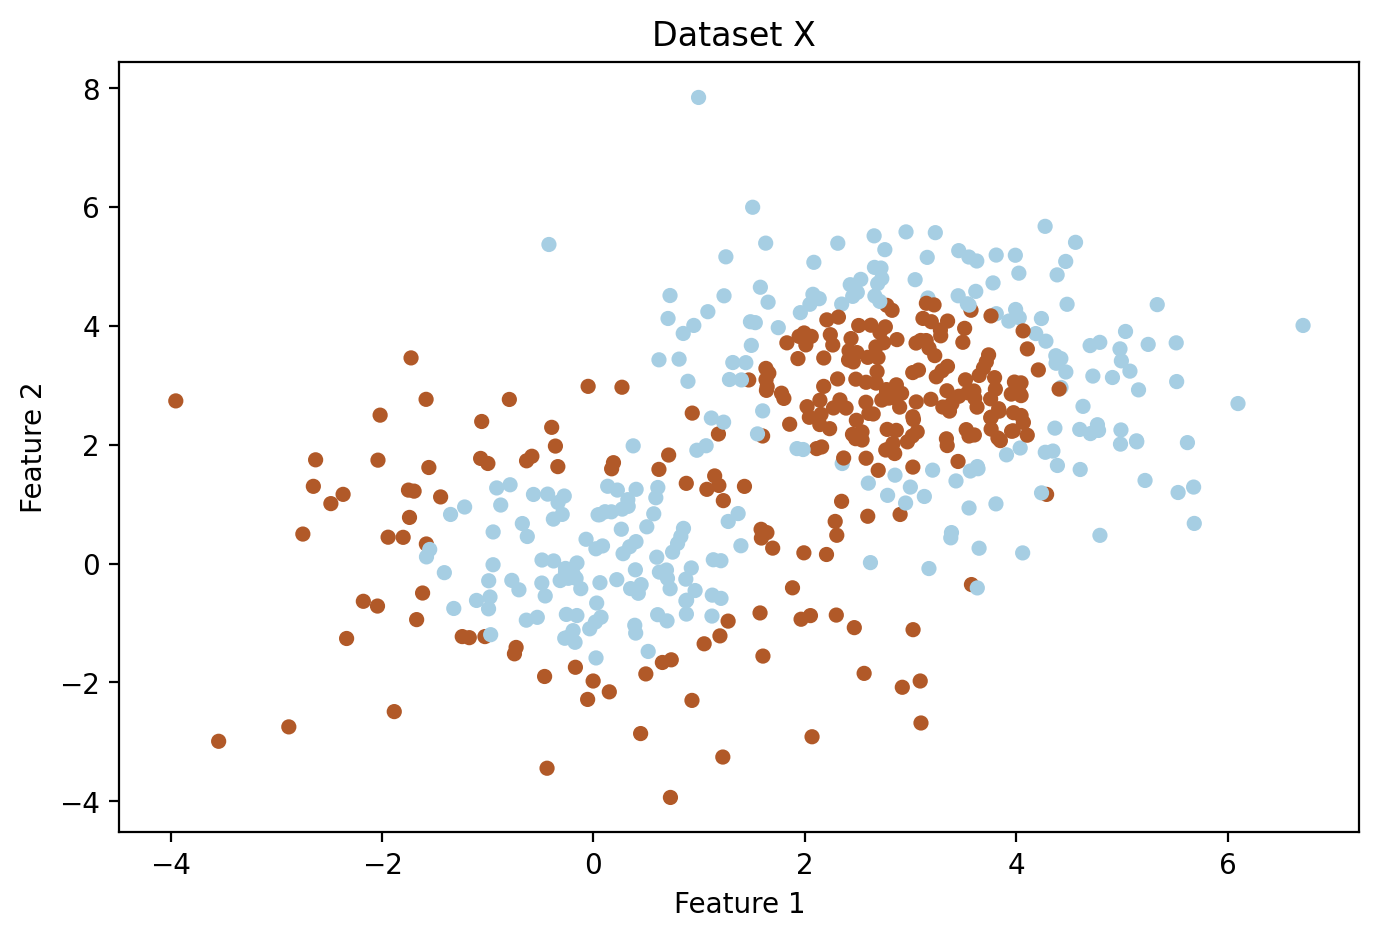

In [5]:
plt.figure(figsize=(8, 5), dpi=200)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20) # type: ignore
plt.title("Dataset X ")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

In [6]:
# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200)
bdt.fit(X, y)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=200)

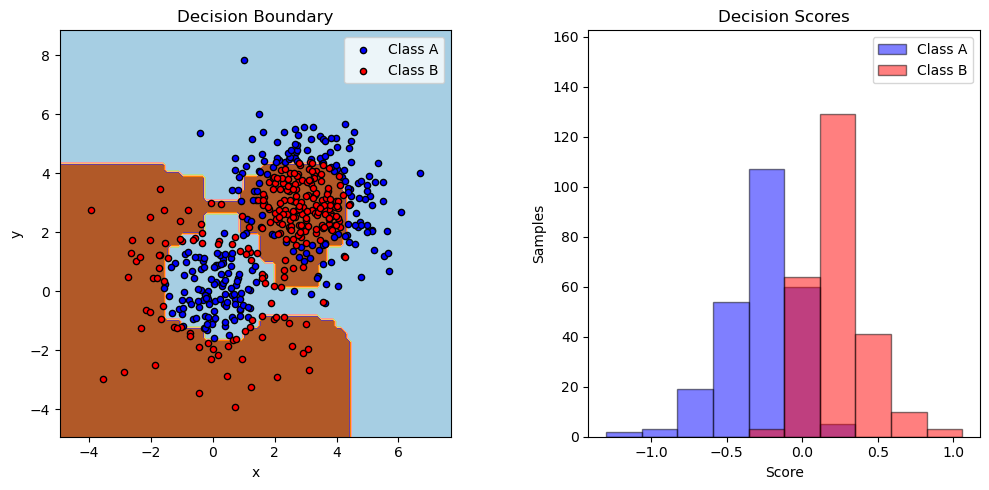

In [ ]:
plot_colors = "br"
plot_step = 0.02
class_names = "AB"

plt.figure(figsize=(10, 5))

# Plot the decision boundaries
ax = plt.subplot(121)
disp = DecisionBoundaryDisplay.from_estimator(
    bdt,
    X,
    cmap=plt.cm.Paired, # type: ignore
    response_method="predict",
    ax=ax,
    xlabel="x",
    ylabel="y",
)
x_min, x_max = disp.xx0.min(), disp.xx0.max() # type: ignore
y_min, y_max = disp.xx1.min(), disp.xx1.max() # type: ignore
plt.axis("tight")

# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = (y == i).nonzero() #nonzero() returns the index of 1s, because others are 0s
    plt.scatter(
        X[idx, 0],
        X[idx, 1],
        c=c,
        s=20,
        edgecolor="k",
        label="Class %s" % n,
    )
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc="upper right")

plt.title("Decision Boundary")

# Plot the two-class decision scores
twoclass_output = bdt.decision_function(X) # this is the score
plot_range = (twoclass_output.min(), twoclass_output.max())
plt.subplot(122)
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(
        twoclass_output[y == i],
        bins=10,
        range=plot_range,
        facecolor=c,
        label="Class %s" % n,
        alpha=0.5,
        edgecolor="k",
    )
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc="upper right")
plt.ylabel("Samples")
plt.xlabel("Score")
plt.title("Decision Scores")

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()

# [LightGBM](https://lightgbm.readthedocs.io/en/stable/)

## Gradient Boosting

1. Start (Initialisation) from a weak learner $F_0(x)$. For example
$$F_0(x) = \arg\min_c \sum_{i=1}^n L(y_i, c)$$
It can be so weak that you do not even need $x$ variable in this example (e.g., sample mean).

2. How to improve? Think Taylor rule!!!
$$F(x) = F(x_0) + \nabla F(\tilde{x})(x-x_0)$$

3. Let's find the gradient (ML way to say partial derivative).
$$r_i^{(m)}=-\left(\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\right)_{F=F_{m-1}}$$
where $m$ is the $m$ th iteration. 

4. The *residual* is clearly NOT the Taylor expansion, however,
    - We do not need to go *deep* for the model parameters.
    - We only need to look at the loss function superficially.
    - We **learn** it!
    - The whole part $\nabla F(\tilde{x})(x-x_0)$ is learned together.

5. Train another weak learner $h_m(x)$ to fit the residual $r^{(m)}_i$.
    - This $h_m(x)$ approximate the partial derivative.
    - Heuristically, each $x$ (or future $x$) would indicates a direction to improve the loss function via $h_m(x)$, approximately.
    - $h$ is usually a tree.

6. For rubustness, we need a *learning rate* to update the new function.
$$F_m(x) = F_{m-1}(x) + \eta h_m(x)$$

7. Repeat many times until you are happy. 
    - This step is tricky. Some stopping rules should apply.

**Fun Fact**: After the first round boosting, gradient information is incorporated into $F_1(x)$. Then the next round, the weak learner starts to learn the **second derivative** implicitly, which will boost precision as indicated by the Taylor rule. Do you get it?

In [3]:
df_train = pd.read_csv('./assignment/train_data.csv')
df_test = pd.read_csv('./assignment/test_data.csv')
df_solution = pd.read_csv('assignment/solution.csv')

In [4]:
X_name_list = [col for col in df_train.columns if col not in ['ID', 'Y']]
X = df_train[X_name_list]
y = df_train['Y']
X_test = df_test[X_name_list]
y_test = df_solution['Y']

In [5]:
gb_reg = GradientBoostingRegressor(
    n_estimators=1000,      
    learning_rate=0.05,   
    max_depth=3,          
    random_state=42
)


In [6]:
gb_reg.fit(X, y)
y_pred = gb_reg.predict(X_test)
print("MSE=", mean_squared_error(y_test, y_pred))

MSE= 5.305392761393661


## LightGBM

From Microsoft, same idea, but
- Faster training speed and higher efficiency.
- Lower memory usage.
- Better accuracy.
- Support of parallel, distributed, and GPU learning.
- Capable of handling large-scale data.

In [6]:
## some repetition
df_train = pd.read_csv('./assignment/train_data.csv')
df_test = pd.read_csv('./assignment/test_data.csv')
df_solution = pd.read_csv('assignment/solution.csv')

X_name_list = [col for col in df_train.columns if col not in ['ID', 'Y']]
X = df_train[X_name_list]
y = df_train['Y']
X_test = df_test[X_name_list]
y_test = df_solution['Y']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

In [8]:
model = LGBMRegressor(
    objective='regression',
    learning_rate=0.05,
    num_leaves=31,
    n_estimators=1000,
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_metric='rmse',  
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 1920, number of used features: 50
[LightGBM] [Info] Start training from score 0.377203


LGBMRegressor(learning_rate=0.05, n_estimators=1000, objective='regression')

## Validation set

- This is an alternative way than cross-validation.

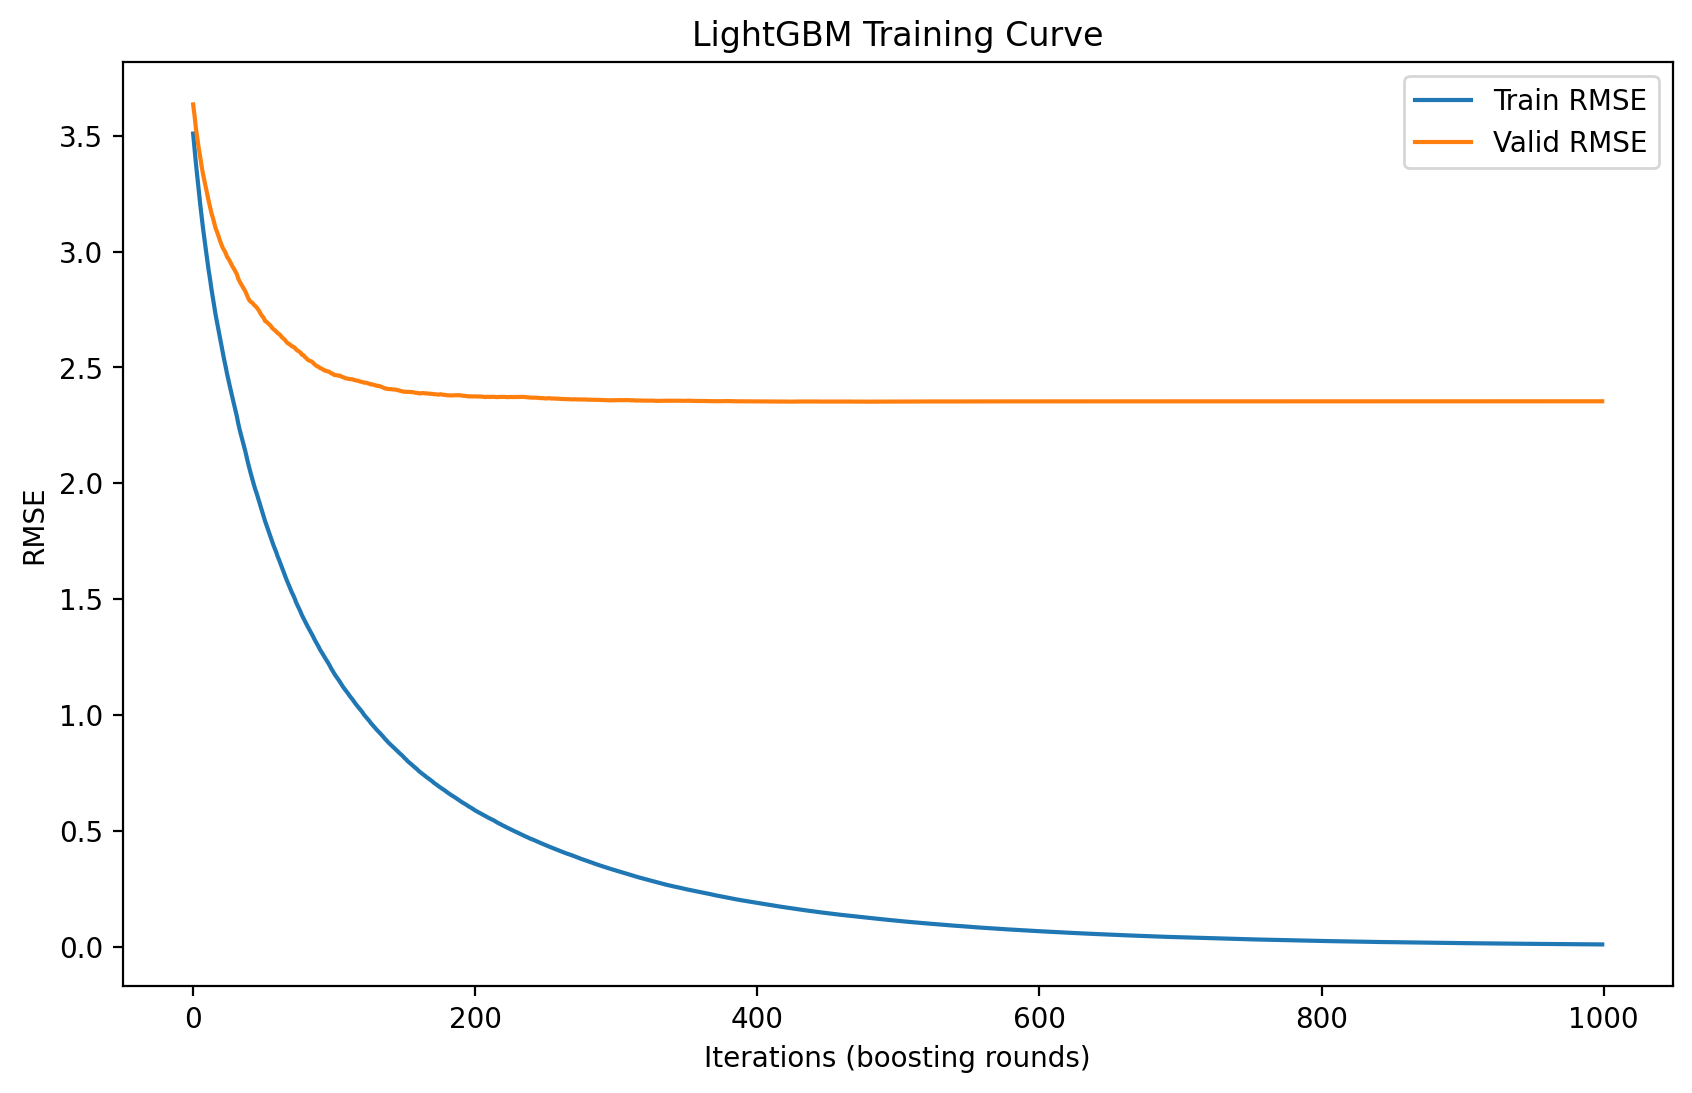

In [9]:
results = model.evals_result_
plt.figure(figsize=(10, 6), dpi=200)
plt.plot(results['training']['rmse'], label='Train RMSE')
plt.plot(results['valid_1']['rmse'], label='Valid RMSE')
plt.xlabel("Iterations (boosting rounds)")
plt.ylabel("RMSE")
plt.title("LightGBM Training Curve")
plt.legend()
plt.show()

In [10]:
print(type(results))
print(results.keys())

<class 'dict'>
dict_keys(['training', 'valid_1'])


In [11]:
best_iter = np.argmin(results['valid_1']['rmse']) + 1
print("Best iteration (manual):", best_iter)

Best iteration (manual): 478


In [12]:
y_pred = model.predict(X_test, num_iteration=best_iter) # type: ignore
# y_pred = model.predict(X_test, num_iteration=400)
print("MSE=", mean_squared_error(y_test, y_pred)) # type: ignore

MSE= 5.852926579502304


# XGBoost (Extreme Gradient Boosting)

- Battle tested!
- [Josh Statmer's youtube illustration](https://www.youtube.com/watch?v=OtD8wVaFm6E)
- [The legendary paper](https://drive.google.com/file/d/1ly2tLdb8PykBtHHGe5WQRDRnxxJJqQGv/view?usp=sharing)

- same idea as Gradient Boosting, but with
    - new way to grow the tree to learn the gradient.
    - Explicitly account for Hessian! This is probably why XGBoost is strong.
    - Regularisations! Bayesian again.

Key parameters
- $\lambda$ regularise/reduce similarity score for
    1. robustness (reduce sensitivity),
    2. Discouraging over splitting.
- $\gamma$: threshold compared to *splitting gain*.
    - If the gain is larger than $\gamma$, then split.
    - It discourage over splitting, too.
- $\eta$: learning rate

In [43]:
iris = load_iris()
X = iris.data # type: ignore
y = iris.target # type: ignore

In [44]:
X = X[y != 2]
y = y[y != 2]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
dtrain = xgb.DMatrix(X_train, label=y_train)

# Set the parameters for the XGBoost model
params = {
    'max_depth': 3,      # Maximum depth of a tree
    'eta': 0.1,          # Learning rate
    'objective': 'binary:logistic',  # Binary classification objective
    'eval_metric': 'logloss'  # Evaluation metric
}

# Train the model
bst = xgb.train(params, dtrain, num_boost_round=10)

In [47]:
# Create a DMatrix for the test set
dtest = xgb.DMatrix(X_test)

# Predict the probability of each class
y_pred_prob = bst.predict(dtest)

# Convert probabilities to binary class labels
y_pred = (y_pred_prob > 0.5).astype(int)

Accuracy is

$$\frac{\text{number of correct predictions}}{\text{number of total predictions}}$$

In [48]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 1.00


## Kaggle Assignment

In [2]:
## some repetition
df_train = pd.read_csv('./assignment/train_data.csv')
df_test = pd.read_csv('./assignment/test_data.csv')
df_solution = pd.read_csv('assignment/solution.csv')

X_name_list = [col for col in df_train.columns if col not in ['ID', 'Y']]
X = df_train[X_name_list]
y = df_train['Y']
X_test = df_test[X_name_list]
y_test = df_solution['Y']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

In [20]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.05,
    n_estimators=500,
    random_state=42,
    gamma=1, # threshold for split
    reg_lambda=1, # L2 regularization
    eval_metric='rmse'
)


In [21]:
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
)

[0]	validation_0-rmse:3.50390	validation_1-rmse:3.64476
[1]	validation_0-rmse:3.42873	validation_1-rmse:3.59483
[2]	validation_0-rmse:3.35474	validation_1-rmse:3.55511
[3]	validation_0-rmse:3.28437	validation_1-rmse:3.50870
[4]	validation_0-rmse:3.21932	validation_1-rmse:3.47223
[5]	validation_0-rmse:3.15625	validation_1-rmse:3.43115
[6]	validation_0-rmse:3.09378	validation_1-rmse:3.39423
[7]	validation_0-rmse:3.03552	validation_1-rmse:3.35728
[8]	validation_0-rmse:2.98055	validation_1-rmse:3.32717
[9]	validation_0-rmse:2.92732	validation_1-rmse:3.30497
[10]	validation_0-rmse:2.87436	validation_1-rmse:3.27707
[11]	validation_0-rmse:2.82681	validation_1-rmse:3.25130
[12]	validation_0-rmse:2.77697	validation_1-rmse:3.23112
[13]	validation_0-rmse:2.73014	validation_1-rmse:3.21104
[14]	validation_0-rmse:2.68282	validation_1-rmse:3.18932
[15]	validation_0-rmse:2.63895	validation_1-rmse:3.17299
[16]	validation_0-rmse:2.59731	validation_1-rmse:3.15248
[17]	validation_0-rmse:2.55557	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

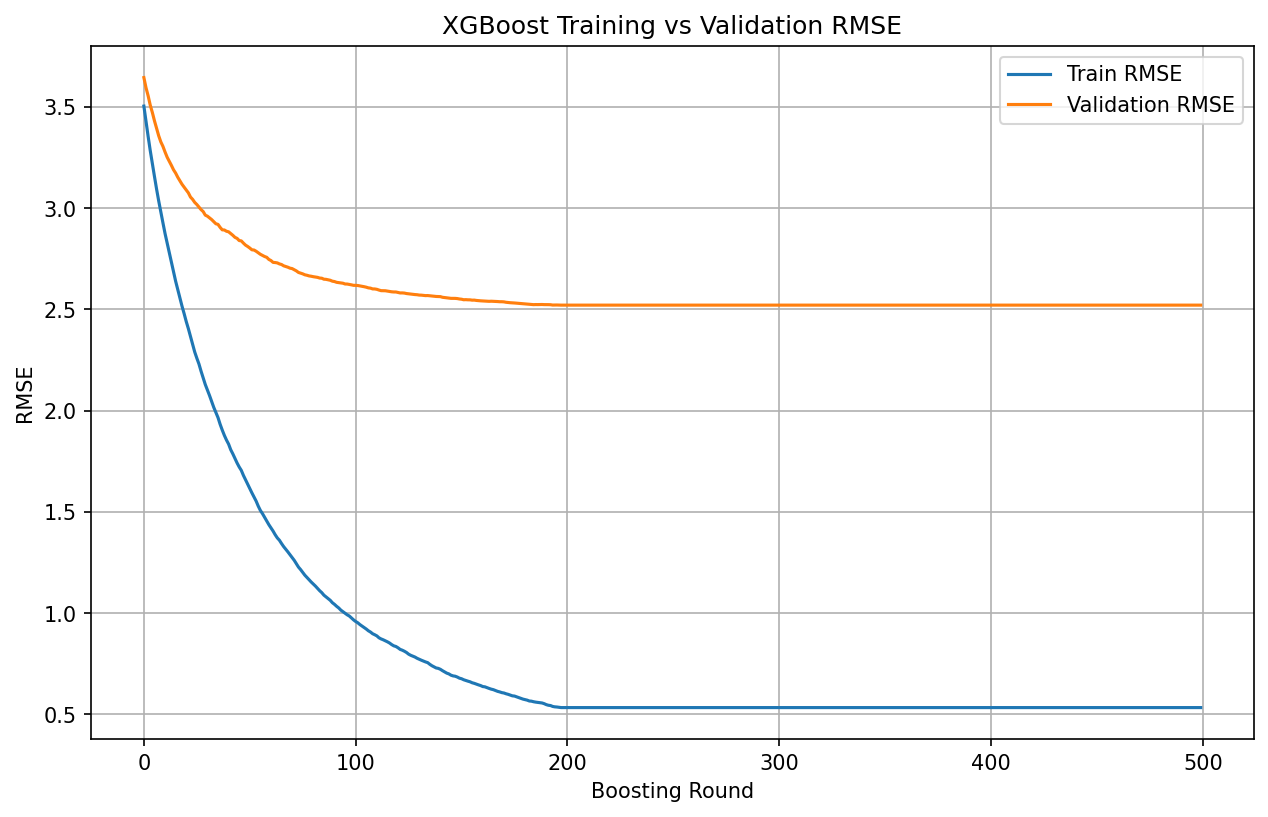

In [22]:
results = xgb_model.evals_result()

train_rmse = results['validation_0']['rmse']
valid_rmse = results['validation_1']['rmse']

plt.figure(figsize=(10, 6), dpi=150)
plt.plot(train_rmse, label='Train RMSE')
plt.plot(valid_rmse, label='Validation RMSE')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('XGBoost Training vs Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
best_iter = np.argmin(results['validation_1']['rmse']) + 1
print("Best iteration (manual):", best_iter)

Best iteration (manual): 198


In [23]:
y_pred = xgb_model.predict(X_test, iteration_range=(0, best_iter+1)) # type: ignore

print("MSE=", mean_squared_error(y_test, y_pred)) # type: ignore

MSE= 6.563026225479566


## More regularisations

In [ ]:
# Define parameter grid
param_grid = {
    'gamma': [0, 0.5, 1, 1.5, 2],
    'reg_lambda': [0, 0.5, 1, 1.5, 2],
}

# Create base model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.05,
    n_estimators=500,
    random_state=42,
    eval_metric='rmse'
)

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # use all available cores
    verbose=1
)

In [26]:
# Fit grid search
grid_search.fit(X, y)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    feature_weights=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=No...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=500,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.5, 1, 1.5, 2],
                         'reg_lambda': [0, 0.5, 1, 1.5, 2]},
             scoring='neg_mean_squared_error', verbose=1)

In [28]:
# Print results
print("Best parameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

Best parameters: {'gamma': 0, 'reg_lambda': 2}
Best MSE: 5.993219469826437


In [ ]:
# Use best parameters to create final model
best_model = xgb.XGBRegressor( # type: ignore
    objective='reg:squarederror',
    learning_rate=0.05,
    n_estimators=500,
    random_state=42,
    gamma=grid_search.best_params_['gamma'], # type: ignore
    reg_lambda=grid_search.best_params_['reg_lambda'], # type: ignore
    eval_metric='rmse'
)

# Train final model
best_model.fit(X, y)# type: ignore

# Make predictions
y_pred = best_model.predict(X_test)# type: ignore
print("Test MSE:", mean_squared_error(y_test, y_pred))# type: ignore

Test MSE: 5.855830669951664


In [ ]:
df_submission = pd.read_csv('./assignment/submission.csv')# type: ignore
# df_submission.info()
df_submission['Y'] = y_pred# type: ignore
df_submission.to_csv('./assignment/submission.csv', index=False)